# <right><font color=navy blue>CSCI492-Signal Processing</font>
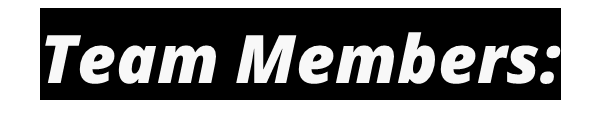
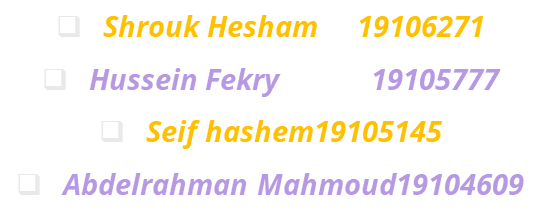

# <center><font color=brown>Identification and Analysis of Saccadic Eye Movements using Signal Processing and Modeling</font>

## Importing Libraries

In [48]:
import numpy as np

In [49]:
import scipy
import os
import sys

In [50]:
from scipy import signal
from scipy import sparse
from scipy.sparse import linalg as slin
from __future__ import division

In [51]:
import matplotlib
matplotlib.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import ImageTk, Image

In [52]:
import tkinter as tk

## Defining our Saccade Model

### We will simulates saccade waveforms using a parametric model, as the saccade model corresponds to the 'main sequence' formula:
        Vp = eta*(1 - exp(-A/c))
    where Vp is the peak saccadic velocity and A is the saccadic amplitude.
   
    Usage:
        waveform, velocity, peak_velocity = 
            saccade_model(t, [eta,] [c,] [amplitude,] [t0,] [s0])
    
    Input:
        t         : time axis (sec)
        eta       : main sequence parameter (deg/sec)
        c         : main sequence parameter (no units)
        amplitude : amplitude of saccade (deg)
        t0        : saccade onset time (sec)
        s0        : initial saccade angle (degree)

    Output:
        waveform      : time series of saccadic angle
        velocity      : time series of saccadic angular velocity
        peak_velocity : peak velocity of saccade

In [53]:
def saccade_model(t, eta=600.0, c=6.0, amplitude=9.5, t0=0.0, s0=0.0):    
    fun_f = lambda t: t*(t>=0)+0.25*np.exp(-2*t)*(t>=0)+0.25*np.exp(2*t)*(t<0)
    fun_df = lambda t: 1*(t>=0)-0.5*np.exp(-2*t)*(t>=0)+0.5*np.exp(2*t)*(t<0)
    tau = amplitude/eta         # tau: amplitude parameter (amplitude = eta*tau)
    if t0 == 0:
        t0 = -tau/2             # saccade onset time (sec)
    
    waveform = c * fun_f(eta * (t-t0)/c) - c * fun_f(eta * (t-t0-tau)/c) + s0
    velocity = eta * fun_df(eta * (t-t0)/c) - eta * fun_df(eta * (t-t0-tau)/c)
    peak_velocity = eta * (1 - np.exp(-amplitude/c))
    
    return waveform, velocity, peak_velocity

In [54]:
if sys.version_info[0] < 3:
    import Tkinter as tk
else:
    import tkinter as tk

In [55]:
def restart_program():
    """
    Restart the program.
    """
    python = sys.executable
    os.execl(python, python, * sys.argv)

In [56]:
def resize(event):
    """
    Not used.
    """
    win_width_c = root.winfo_width()
    win_height_c = root.winfo_height()
    fig.set_size_inches(fig_width*win_width_c/win_width, fig_height*win_height_c/win_height)

In [57]:
def diff(x):
    """
    Calculate derivative.
    """
    h = np.array([0.5, 0, -0.5])
    y = signal.convolve(x, Fs*h, mode='same')
    y[0] = 0
    y[-1] = 0
    return y

In [58]:
def rmse(x, y):
    """
    Calculate root-mean-square-error.
    """
    z = np.sqrt(np.mean((x-y)**2))
    return z

In [59]:
def make_saccade(event):
    """
    Generate multiple saccades.
    """
    sacc_eta = eta.get()
    sacc_c = c.get()
    sacc_amp = amplitude.get()
    sacc_sigma = sigma.get()
    sacc_n = int(n.get())
    global t, s, y, w, N, x, e, D1, D3, I, ALPHA, BETA, sacc_dur
    

    
    if sacc_n > 1:
        waveform, velocity, peak_velocity = saccade_model(T, sacc_eta, sacc_c, sacc_amp)
        s = waveform
        for i in range(1, sacc_n):
            waveform, velocity, peak_velocity = saccade_model(T, sacc_eta, sacc_c, sacc_amp, -sacc_amp/sacc_eta/2, (-1 if i%2 else 1)*s[-1])
            s = np.concatenate((s, (-1 if i%2 else 1)*waveform))
    else:
        waveform, velocity, peak_velocity = saccade_model(T, sacc_eta, sacc_c, sacc_amp)
        s = waveform
    N = len(s)
    t = np.arange(N)/Fs
    if len(w) != N:
        w = np.random.randn(N)
    y = s + w * sacc_sigma 
    x = y
    
    if len(e) != N:
        e = np.ones(N)
        D1 = sparse.spdiags([-e, e], [0, 1], N-1, N)
        D3 = sparse.spdiags([-e, 3*e, -3*e, e], [0, 1, 2, 3], N-3, N)
        I = sparse.spdiags(e, 0, N, N)
    sd1 = diff(s)
    yd1 = diff(y)
    line1_y.set_data(t, y)
    p1.set_xlim((0,(N-1)/Fs))
    line2_y.set_data(t, yd1)
    p2.set_xlim((0,(N-1)/Fs))
    if sacc_n > 1:
        p2.set_ylim((-750,750))
    else:
        p2.set_ylim((-50,750))
    line1_0.set_data(t, s)
    line2_0.set_data(t, sd1)
    fig.canvas.draw()
    
    sacc_dur = np.sum(abs(sd1)>30)/Fs/sacc_n
    alpha = 8*sacc_sigma
    beta = 4*sacc_sigma*np.sqrt(sacc_amp)*np.exp(5*sacc_dur)
    lam1.set(alpha)
    lam2.set(beta)
    denoiseButton(3)
    ALPHA = 0
    BETA = 0

In [60]:
def denoise(event):
    """
    Run CGTV to denoise the data.
    """
    alpha = lam1.get()
    beta = lam2.get()
    global x
    for i in range(3):    
        Lam1 = sparse.spdiags(alpha/psi(np.diff(x)), 0, N-1, N-1)
        Lam3 = sparse.spdiags(beta/psi(np.diff(x,3)), 0, N-3, N-3)
        temp = I + ((D1.T).dot(Lam1)).dot(D1) + ((D3.T).dot(Lam3)).dot(D3)
        x = slin.spsolve(temp, y)
    xd1 = diff(x)
    line1_d.set_data(t, x)
    line2_d.set_data(t, xd1)
    err = rmse(x, s)
    p1.set_title('Simulated Eye Movement Data (RMSE = %.4f)' % err)
    fig.canvas.draw()

In [61]:
def denoiseButton(Nit):
    """
    Run CGTV to denoise the data.
    """
    alpha = lam1.get()
    beta = lam2.get()
    global x
    for i in range(Nit):    
        Lam1 = sparse.spdiags(alpha/psi(np.diff(x)), 0, N-1, N-1)
        Lam3 = sparse.spdiags(beta/psi(np.diff(x,3)), 0, N-3, N-3)
        temp = I + ((D1.T).dot(Lam1)).dot(D1) + ((D3.T).dot(Lam3)).dot(D3)
        x = slin.spsolve(temp, y)
    xd1 = diff(x)
    line1_d.set_data(t, x)
    line2_d.set_data(t, xd1)
    err = rmse(x, s)
    p1.set_title('Simulated Eye Movement Data (RMSE = %.4f)' % err)
    fig.canvas.draw()

In [62]:
def denoiseDefault():
    """
    Use default parameters for CGTV to denoise the data.
    """
    sacc_amp = amplitude.get()
    sacc_sigma = sigma.get()
    alpha = 8*sacc_sigma
    beta = 4*sacc_sigma*np.sqrt(sacc_amp)*np.exp(5*sacc_dur)
    lam1.set(alpha)
    lam2.set(beta)
    denoiseButton(Nit_max)

In [63]:
def new_noise():
    """
    Generate new noise realization.
    """
    global w, y, ALPHA, BETA
    sacc_sigma = sigma.get()
    w = np.random.randn(N)
    y = s + w * sacc_sigma 

    yd1 = diff(y)
    line1_y.set_data(t, y)
    line2_y.set_data(t, yd1)

    denoiseButton(3)
    ALPHA = 0
    BETA = 0
    
    fig.canvas.draw()

In [64]:
def show_raw():
    """
    Show noise-free data.
    """
    if raw.get() == 1:
        line1_0.set_alpha(1)
        line2_0.set_alpha(1)
    else:
        line1_0.set_alpha(0)
        line2_0.set_alpha(0)
    fig.canvas.draw()

In [65]:
def switchStatus0(event):
    """
    Turn off background computing.
    """
    global IDLING
    IDLING = 0
 
def switchStatus1(event):
    """
    Turn on background computing.
    """
    global IDLING
    IDLING = 1

In [66]:
def denoise_conti():
    """
    Run CGTV to denoise the data.
    """
    alpha = lam1.get()
    beta = lam2.get()
    root.after(1000, denoise_conti)
    if IDLING == 0:
        return
    
    global x, ALPHA, BETA
    if alpha != ALPHA or beta != BETA:
        ALPHA = alpha
        BETA = beta
    else:
        return
    
    for i in range(Nit_max):

        Lam1 = sparse.spdiags(alpha/psi(np.diff(x)), 0, N-1, N-1)
        Lam3 = sparse.spdiags(beta/psi(np.diff(x,3)), 0, N-3, N-3)
        temp = I + ((D1.T).dot(Lam1)).dot(D1) + ((D3.T).dot(Lam3)).dot(D3)
        x = slin.spsolve(temp, y)

    xd1 = diff(x)
    line1_d.set_data(t, x)
    line2_d.set_data(t, xd1)
    err = rmse(x, s)

    p1.set_title('Simulated Eye Movement Data (RMSE = %.4f)' % err)
    fig.canvas.draw()

In [67]:
EPS = 1E-10;                # smoothed penalty function
psi = lambda x: np.sqrt(x**2 + EPS)
Nit_max = 50
ALPHA = 0
BETA = 0
IDLING = 0

root = tk.Tk()
root.title('Saccade Denoising Demo')
win_width = 1620
win_height = 880


# Define variables
eta = tk.DoubleVar(value=600.0)         # saccade parameter, eta
c = tk.DoubleVar(value=6.0)             # saccade parameter, c
amplitude = tk.DoubleVar(value=20.0)    # saccade amplitude
sigma = tk.DoubleVar(value=0.1)         # noise parameter
raw = tk.IntVar()                       # display raw data or not
ms = tk.IntVar(value=1)                 # display main sequence or not
lam1 = tk.DoubleVar(value=0)            # denoising parameter 1
lam2 = tk.DoubleVar(value=0)            # denoising parameter 2
n = tk.StringVar(value='1')             # number of saccades

# <center><font color=blue>GUI</font>

### Drop down menu 

In [68]:
myMenu = tk.Menu(root)
root.config(menu=myMenu)
subMenu_1 = tk.Menu(myMenu)
myMenu.add_cascade(label='Menu', menu=subMenu_1)
subMenu_1.add_command(label='Restart', command=restart_program)
subMenu_1.add_separator()
subMenu_1.add_command(label='Close', command=root.quit)

### Frames

In [69]:
rightFrame = tk.Frame(root)
rightFrame.pack(side='right', expand=0)

topFrame = tk.Frame(root)
topFrame.pack(side='top', fill='x', expand=0)

### Top frame ###
title = tk.Label(topFrame, text='Saccade Denoising Demo', font=('times', 24, 'bold'))
title.pack(side='top')
intro_string = 'The peak velocity '+r'$\bf{V_p}$ ' \
                'and amplitude '+r'$\bf{A}$ '+'of the simulated saccades satisfy the relation ' \
                r'$V_p=\eta(1-e^{-A/c})$ '+'.\n' \
                'Fast, regular, or slow saccades can be simulated via tuning the parameters ' \
                r'$\bf{\eta}$ '+'and '+r'$\bf{c}$' + '.\n' \
                'The parameters '+r'$\bf{\alpha}$ ' \
                'and ' \
                +r'$\bf{\beta}$ ' \
                'control the denoising behaviour of the method.'


### Left frame ###
Fs = 500.0
T = np.arange(-0.15, 0.15+1.0/Fs, 1.0/Fs)
waveform, velocity, peak_velocity = saccade_model(T, 600, 6, 10)
w = np.array([0])
N = len(T);
e = np.ones(N)
D1 = sparse.spdiags([-e, e], [0, 1], N-1, N)
D3 = sparse.spdiags([-e, 3*e, -3*e, e], [0, 1, 2, 3], N-3, N)
I = sparse.spdiags(e, 0, N, N)

# Position plot
fig = matplotlib.figure.Figure()
fig_width = fig.get_figwidth()
fig_height = fig.get_figheight()

p1 = fig.add_subplot(2, 1, 1)
line1_y, = p1.plot(T, waveform, color='k', linewidth=1.8, label='Noisy')
line1_d, = p1.plot(T, waveform, color='r', linewidth=1.5, label='Denoised')
line1_0, = p1.plot(T, waveform, color='b', alpha=0, linewidth=1.5)
p1.set_xlim((-0.15,0.15))
p1.set_ylim((-1,30))

p1.set_ylabel('Position (deg)')
p1.set_title('Simulated Eye Movement Data')
p1.legend(loc='upper left')

In [70]:
# Velocity plot
p2 = fig.add_subplot(2, 1, 2)
line2_y, = p2.plot(T, velocity, color='k', linewidth=1.8, label='Noisy')
line2_d, = p2.plot(T, waveform, color='r', linewidth=1.5, label='Denoised')
line2_0, = p2.plot(T, velocity, color='b', alpha=0, linewidth=1.5)
p2.set_xlim((-0.15,0.15))
p2.set_ylim((-50,750))
p2.set_xlabel('Time (s)')
p2.set_ylabel('Velocity (deg/s)')
p2.legend(loc='upper left')

In [71]:
canvas = FigureCanvasTkAgg(fig, master = root)

canvas.get_tk_widget().pack(fill = tk.BOTH, expand = 1)

In [72]:
### Right frame ###
# Saccade parameters
font1 = ('times',18)
font2 = ('times',15,'italic')
label_1 = tk.Label(rightFrame, text='Saccade Parameters:', font=font1)
label_1.grid(row=0, column=1, columnspan=4, sticky='w')
paramLabel_eta = tk.Label(rightFrame, text=u'\u03b7', font=font2)
paramLabel_eta.grid(row=1, column=0, sticky='e')
paramScale_eta = tk.Scale(rightFrame, orient='horizontal', length = 200, variable=eta, from_=200, to=800, command=make_saccade)
paramScale_eta.grid(row=1, column=1, columnspan=3)
paramLabel_c = tk.Label(rightFrame, text='c', font=font2)
paramLabel_c.grid(row=2, column=0, sticky='e')
paramScale_c = tk.Scale(rightFrame, orient='horizontal', length = 200, variable=c, from_=2, to=12, resolution=0.2, command=make_saccade)
paramScale_c.grid(row=2, column=1, columnspan=3)
paramLabel_A = tk.Label(rightFrame, text='Amplitude', font=font2)
paramLabel_A.grid(row=3, column=0, sticky='e')
paramScale_A = tk.Scale(rightFrame, orient='horizontal', length = 200, variable=amplitude, from_=1, to=30, resolution=0.5, command=make_saccade)
paramScale_A.grid(row=3, column=1, columnspan=3)
paramLabel_n = tk.Label(rightFrame, text='# Saccades', font=font2)
paramLabel_n.grid(row=4, column=0, sticky='e')
paramDropMenu_n = tk.OptionMenu(rightFrame, n, '1', '2', '3', '4', command=make_saccade)
paramDropMenu_n.config(width=15, bg='gray')
paramDropMenu_n.grid(row=4, column=1, columnspan=3)

In [73]:
# Noise parameter
label_2 = tk.Label(rightFrame, text='Noise Parameter:', font=font1)
label_2.grid(row=5, column=1, columnspan=4, sticky='w')
paramLabel_sigma = tk.Label(rightFrame, text=u'\u03c3', font=font2)
paramLabel_sigma.grid(row=6, column=0, sticky='e')
paramScale_sigma = tk.Scale(rightFrame, orient='horizontal', length = 200, variable=sigma, from_=0, to=1, resolution=0.02, command=make_saccade)
paramScale_sigma.grid(row=6, column=1, columnspan=3)
paramScale_sigma.set(0.5)
button_noise = tk.Button(rightFrame, text='Update noise', width=20, height=2, command=new_noise)
button_noise.grid(row=7, column=1, columnspan=3)

# Show noise-free data
check_box_1 = tk.Checkbutton(rightFrame, text='Show clean data', variable=raw, command=show_raw)
check_box_1.grid(row=8, column=1, columnspan=3)

In [74]:
# Denoising Parameters
label_3 = tk.Label(rightFrame, text='Denoising Parameters:', font=font1)
label_3.grid(row=9, column=1, columnspan=4, sticky='w')
photo = Image.open('cost.png')
photow, photoh = photo.size

cost_function = ImageTk.PhotoImage(photo)
label_cost = tk.Label(rightFrame, image=cost_function)
label_cost.grid(row=10, columnspan=5)

paramLabel_alpha = tk.Label(rightFrame, text=u'\u03b1', font=font2)
paramLabel_alpha.grid(row=11, column=0, sticky='e')

alpha_max = 15;
paramScale_alpha = tk.Scale(rightFrame, orient='horizontal', command=denoise, length = 200, variable=lam1, from_=0, to=alpha_max, resolution=0.05)

paramScale_alpha.grid(row=11, column=1, columnspan=3)
paramLabel_beta = tk.Label(rightFrame, text=u'\u03b2', font=font2)
paramLabel_beta.grid(row=12, column=0, sticky='e')

beta_max = 20
paramScale_beta = tk.Scale(rightFrame, orient='horizontal', command=denoise, length = 200, variable=lam2, from_=0, to=beta_max, resolution=0.05)

paramScale_beta.grid(row=12, column=1, columnspan=3)
"""
paramEntry_alpha = tk.Entry(rightFrame, textvariable=lam1)
paramEntry_alpha.grid(row=10, column=1, columnspan=1)
paramEntry_beta = tk.Entry(rightFrame, textvariable=lam2)
paramEntry_beta.grid(row=11, column=1, columnspan=1)
button_denoise = tk.Button(rightFrame, text='Denoise', width=20, height=2)
button_denoise.bind("<ButtonRelease-1>", denoise)
button_denoise.grid(row=12, column=1, columnspan=3)
"""

'\nparamEntry_alpha = tk.Entry(rightFrame, textvariable=lam1)\nparamEntry_alpha.grid(row=10, column=1, columnspan=1)\nparamEntry_beta = tk.Entry(rightFrame, textvariable=lam2)\nparamEntry_beta.grid(row=11, column=1, columnspan=1)\nbutton_denoise = tk.Button(rightFrame, text=\'Denoise\', width=20, height=2)\nbutton_denoise.bind("<ButtonRelease-1>", denoise)\nbutton_denoise.grid(row=12, column=1, columnspan=3)\n'

In [75]:
button_params = tk.Button(rightFrame, text='Default Parameters', width=20, height=2, command=denoiseDefault)
button_params.grid(row=13, column=1, columnspan=3)

paramLabel_7 = tk.Label(rightFrame, text=' ')
paramLabel_7.grid(row=19, column=0)

button_exit = tk.Button(rightFrame, text='Exit', width=20, height=2, command=root.quit)
button_exit.grid(row=20, column=1, columnspan=3)

denoise_conti()

root.bind("<ButtonPress>", switchStatus0)
root.bind("<ButtonRelease>", switchStatus1)

label_reference = tk.Label(root, text = '"Identification and Analysis of Saccadic Eye Movements using Signal Processing and Modeling" \nUnder Supervision of: DR. Walid , Eng. Shahenda', justify = tk.LEFT)

label_reference.pack(side = tk.LEFT)

root.mainloop()